# Data Analysis on Pitchfork Music Reviews

## Table of Contents
- Introduction
- Characteristics of the Dataset
- How are review scores distributed?
- Genres
	- What's the most reviewed genre?
	- What's the highest rated genre?
	- ANOVA Test on the Top 3 Most Revieved Genres
	- What was the highest rated genre of each year?
- Reviews Over Time
	- How did the average review score change over the years?
- Labels
	- Which labels perform well on Pitchfork?
	- Comparing Performance of Independent Labels vs. Major Labels
	- Independent Z-Test on Major and Independent Groups
- Conclusion

## Introduction

The [dataset](https://www.kaggle.com/nolanbconaway/pitchfork-data) used in this analysis contains data on 18 393 reviews from the music review site [Pitchfork](https://pitchfork.com). Analysis of this data can be used to show bias towards certain genres, artists, and labels. Furthermore, it can be used to confirm or deny trends in reviews over 18 years. As one of the most well known sites for music reviews, and with a large influence on popular opinion, analysis of these reviews could show whether or not it can be trusted as an authoritative review site.

## Characteristics of the Dataset

The dataset is divided into 6 separate tables since some reviews require multiple entries for a single column (ex: some reviews have multiple artists, genres, labels, and years). There are 17 unique columns over all the tables and 18 393 rows on the main reviews table.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from functools import reduce
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

connection = sqlite3.connect('pitchfork-data/database.sqlite')

# Creating DataFrames for each table
artists = pd.read_sql_query('SELECT * FROM artists', connection)
reviews = pd.read_sql_query('SELECT * FROM reviews', connection)
genres = pd.read_sql_query('SELECT * FROM genres', connection)
labels = pd.read_sql_query('SELECT * FROM labels', connection)
years = pd.read_sql_query('SELECT * FROM years', connection)
content = pd.read_sql_query('SELECT * FROM content', connection)

In [2]:
# Special colour for graphs
p4k_red = '#ff3530'

# How are review scores distributed?

We can see that review scores follow a roughly normal distribution centered over a mean score of $7.006$ with a standard deviation of $1.294$.

In [3]:
reviews['score'].describe()

count    18393.000000
mean         7.005779
std          1.293675
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

We use pyplot to plot a histogram of review scores.

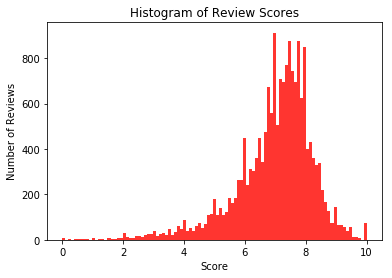

In [4]:
pl.hist(reviews['score'], bins=101, color=p4k_red)
pl.title('Histogram of Review Scores')
pl.xlabel('Score')
pl.ylabel('Number of Reviews');

# Genres

## What's the most reviewed genre?

Rock music is by far the most reviewed genre on the site. Rock music has more than twice the amount of reviews as electronic music, which is the second most reviewed genre.

In [5]:
# Merge the reviews with genres and group by genre.
# Only keep the score column and count the entries per group.
num_genre_reviews = reviews.merge(genres, on='reviewid').groupby('genre')['score'].count()
num_genre_reviews_pd = pd.DataFrame(num_genre_reviews).reset_index()
num_genre_reviews_pd.columns = ['Genre', 'Number of Reviews']
num_genre_reviews_pd.set_index('Genre')

,Number of Reviews
Genre,
electronic,3874
experimental,1815
folk/country,685
global,219
jazz,435
metal,862
pop/r&b,1432
rap,1559
rock,9438


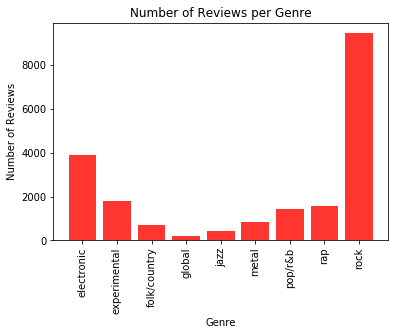

In [6]:
pl.bar(x=num_genre_reviews.index, height=num_genre_reviews, color=p4k_red)
pl.xticks(rotation=90)
pl.title('Number of Reviews per Genre')
pl.xlabel('Genre')
pl.ylabel('Number of Reviews');

## What's the highest rated genre?

All of the genres tend to have an average score between about $6.5$ and $7.5$. Although global music has the highest rating, it is also the least reviewed genre, so individual scores have a higher influence on the genre mean than in other genres.

Between the top 3 most reviewed genres (rock, electronic, experimental), there is sufficient evidence at a $0.05$ significance level that their mean scores differ.

In [7]:
mean_genre_scores = reviews.merge(genres, on='reviewid').groupby('genre')['score'].mean()
mean_genre_scores_pd = pd.DataFrame(mean_genre_scores).reset_index()
mean_genre_scores_pd.columns = ['Genre', 'Mean Score']
mean_genre_scores_pd.set_index('Genre')

,Mean Score
Genre,
electronic,6.920702
experimental,7.336694
folk/country,7.202190
global,7.429680
jazz,7.303908
metal,6.950000
pop/r&b,6.883799
rap,6.900513
rock,6.942011


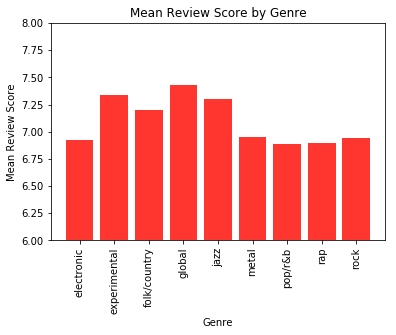

In [8]:
pl.bar(x=mean_genre_scores.index, height=mean_genre_scores, color=p4k_red)
pl.xticks(rotation=90)
pl.title('Mean Review Score by Genre')
pl.xlabel('Genre')
pl.ylabel('Mean Review Score')
pl.ylim(6, 8);

In [9]:
# Use idxmax() to find which index has the highest value
print('Highest rated genre:', mean_genre_scores.idxmax())

Highest rated genre: global


In [10]:
grouped = reviews.merge(genres, on='reviewid').groupby('genre')['score']
# Create an array of the scores of each genre
scores_by_genre = [grouped.get_group(gen) for gen in grouped.groups]

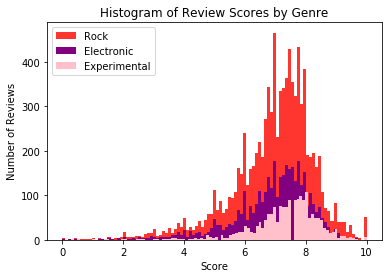

In [11]:
# Graph a histogram for each list of genre scores
for genre, color in [('rock', p4k_red), ('electronic', 'purple'), ('experimental', 'pink')]:
    pl.hist(grouped.get_group(genre), bins=101, color=color);

pl.legend(('Rock', 'Electronic', 'Experimental'))
pl.title('Histogram of Review Scores by Genre')
pl.xlabel('Score')
pl.ylabel('Number of Reviews');

## ANOVA Test on the Top 3 Most Reviewed Genres

Our null hypothesis ($H_0$) is that the mean scores of rock, electronic, and experimental music are equal.

Our alternative hypothesis ($H_1$) is that at least one mean score of rock, electronic, and experimental music differs.

In [12]:
top_3_genre_scores = [grouped.get_group(genre) for genre in ['rock', 'electronic', 'experimental']]

# Perform an ANOVA test using the stats package
F, p = stats.f_oneway(*top_3_genre_scores)
print('F: %f\np: %f' % (F, p))

F: 74.075346
p: 0.000000


$P\approx 0 < 0.05$, so we reject $H_0$. There is sufficient evidence to claim at a $0.05$ significance level that the mean review score between rock, electronic, and experimental music differs.

## What was the highest rated genre of each year?

The "global" genre was the highest rated on average for most years. The second highest rated was "experimental," which was the highest rated in 2001, 2002, and 2007.

In [13]:
# Group by publish year and genre and find the mean score for each group
mean_genre_scores_by_year = reviews.merge(genres, on='reviewid').groupby(['pub_year', 'genre'])['score'].mean()
mean_genre_scores_by_year_pd = pd.DataFrame(mean_genre_scores_by_year).reset_index()
mean_genre_scores_by_year_pd.columns = ['Published Year', 'Genre', 'Mean Score']
mean_genre_scores_by_year_pd.set_index('Published Year').head(9)

,Genre,Mean Score
Published Year,,
1999,electronic,6.797101
1999,experimental,6.707143
1999,folk/country,7.766667
1999,global,8.150000
1999,jazz,7.466667
1999,metal,6.518182
1999,pop/r&b,6.400000
1999,rap,8.333333
1999,rock,6.700714


In [14]:
# Group by published year and aggregate finding the max genre of each year
highest_genres = pd.DataFrame(mean_genre_scores_by_year.groupby(['pub_year']).agg(lambda data: data.idxmax()[1]))
highest_genres = highest_genres.reset_index()
highest_genres.columns = ['Year Published', 'Highest Rated Genre']
highest_genres.set_index('Year Published', inplace=True)
highest_genres

,Highest Rated Genre
Year Published,
1999,rap
2000,folk/country
2001,experimental
2002,experimental
2003,global
2004,global
2005,global
2006,jazz
2007,experimental


# Reviews Over Time

## How did the average review score change over the years?

It appears that there was a slight increase in review scores over the years, but there only exists a very weak correlation between published date and score ($r=0.0463$).


In [15]:
# Resample the time series by every 6 months
reviews['pub_date'] = pd.to_datetime(reviews['pub_date'])
reviews_by_pub = reviews.set_index(['pub_date'])
means_by_year = reviews_by_pub['score'].resample('6M').mean()

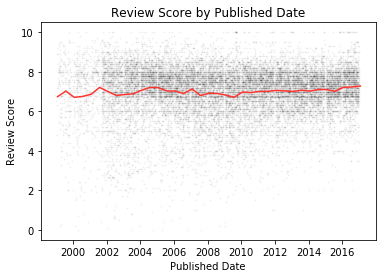

In [16]:
pl.scatter(x=reviews_by_pub.index, y=reviews_by_pub['score'], alpha=0.04, s=1, color='black');
pl.title('Review Score by Published Date')
pl.xlabel('Published Date')
pl.ylabel('Review Score')

pl.plot(means_by_year, linewidth=1.5, color=p4k_red);

In [17]:
# Convert the dates to timestamps for easy correlation calculation
reviews_by_pub['timestamp'] = pd.to_numeric(reviews_by_pub.index)
np.corrcoef(reviews_by_pub['timestamp'], reviews_by_pub['score'])[0, 1]

0.04634873968927449

# Labels

## Which labels perform well on Pitchfork?

In the top 20 labels with the most reviews with a score of at least 8, the majority are independent. Only 5 of the top 20 are from the 3 major labels (Universal/Sony/Warner) and labels owned by them.

In [18]:
# Group by reviews with a score greater than 8
grouped = reviews[reviews['score'] >= 8].merge(labels, on='reviewid').groupby('label')

highRatingsByLabel = pd.DataFrame(grouped.size().sort_values(ascending=False))
highRatingsByLabel = highRatingsByLabel.reset_index()
highRatingsByLabel.columns = ['Label', '# of 8+ Scores']
highRatingsByLabel.set_index('Label', inplace=True)
highRatingsByLabel.head(10)

,# of 8+ Scores
Label,
matador,74
sub pop,72
domino,67
columbia,65
merge,62
warp,60
drag city,59
4ad,53
rhino,49


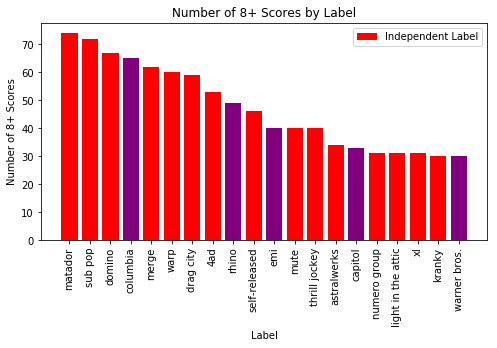

In [19]:
top20Labels = highRatingsByLabel['# of 8+ Scores'].head(20)

independent=['matador', 'sub pop', 'domino', 'merge', 'warp', 'drag city', '4ad', 'self-released', 'mute', 'thrill jockey', 'astralwerks', 'numero group', 'light in the attic', 'xl', 'kranky']
colors=['red' if (label in independent) else 'purple' for label in top20Labels.index]

pl.figure(figsize=(8, 4))
pl.bar(x=top20Labels.index, height=top20Labels, color=colors)
pl.xticks(rotation=90)
pl.title('Number of 8+ Scores by Label')
pl.xlabel('Label')
pl.ylabel('Number of 8+ Scores')
pl.legend(('Independent Label', 'Major Label'));

## Comparing Performance of Independent Labels vs. Major Labels

We found that on average, at a $0.05$ significance level, music from independent labels tends to score higher than music from major labels ($P\approx0$). This value could be slightly off due to the fact that we lacked reliable data for independent and major labels. This value also does not take into account whether or not a release was on a previously independent label which is now owned by a major label. All the data used for major labels is from the current day.


Furthermore, the method used to figure out if a label is major or not is somewhat rudimentary. To find out of a label is major or not, the label is searched for in a text file of major labels. For the most part, it seems to work, but there are some labels that tend to be labelled incorrectly.


It should also be noted that independent labels that are partnered with the Alternative Distribution Alliance (ADA) listed [here](https://en.wikipedia.org/wiki/Alternative_Distribution_Alliance) are not considered major in our analysis. Labels partnered with the ADA, which is owned by Warner Music Group, actually represent many top rated labels on Pitchfork (ex. Matador, Sub Pop, Domino, Merge, Warp). Including these labels as major could have affected the results, along with the fact that some independent labels end up being owned by major labels.

In [20]:
# Figures out of a label is independent or not and returns that value
def is_independent(label):
    if not label or len(label) <= 2:
        return True
    
    regex = r'\n' + label + r'[\b\s]'
    for label_list in major_labels:
        if re.search(regex, label_list, re.IGNORECASE):
            return False
    
    return True

In [21]:
warner = open('./labels/warner.txt', 'r')
universal = open('./labels/universal.txt', 'r')
sony = open('./labels/sony.txt', 'r')

def read_list(stream):
    text = stream.read()
    stream.close()
    return text.lower()

major_labels = np.array(list(map(read_list, [warner, universal, sony])))

In [22]:
import re

# Have a dict storing whether or not labels are independent or not
label_dict = {}

all_labels = reviews.merge(labels, on='reviewid').groupby('label').last().index
for label in all_labels:
    label_dict[label] = is_independent(label)

label_df = pd.DataFrame(data={'label': list(label_dict.keys()), 'independent': list(label_dict.values())})
label_df.set_index('label', inplace=True)
label_df = label_df.merge(labels, on='label')

In [23]:
reviews_by_label = reviews.merge(label_df, on='reviewid')
reviews_by_label.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,label,independent
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,virgin,False
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,hathenter,True
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,fashionable idiots,True
3,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,static shock,True
4,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,kill rock stars,True


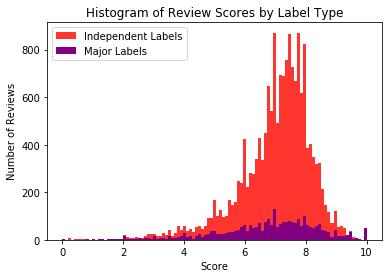

In [24]:
# Separate reviews by major and independent labels
reviews_major = reviews_by_label[reviews_by_label['independent'] == False]
reviews_indie = reviews_by_label[reviews_by_label['independent'] == True]

pl.hist(reviews_indie['score'], bins=101, color=p4k_red)
pl.hist(reviews_major['score'], bins=101, color='purple');

pl.legend(('Independent Labels', 'Major Labels'));
pl.title('Histogram of Review Scores by Label Type')
pl.xlabel('Score')
pl.ylabel('Number of Reviews');

In [25]:
print('Major label mean score: %f' % np.mean(reviews_major['score']))
print('Major label sample standard deviation: %f' % np.std(reviews_major['score'], ddof=1) + '\n')
print('Independent label mean score: %f' % np.mean(reviews_indie['score']))
print('Independent label sample standard deviation: %f' % np.std(reviews_indie['score'], ddof=1))

Major label mean score: 6.804308
Major label sample standard deviation: 1.678621

Independent label mean score: 7.035129
Independent label sample standard deviation: 1.230415


## Independent Z-Test on Major and Independent Groups

Let $\mu_1$ be the population mean of major label review scores.

Let $\mu_2$ be the population mean of independent label review scores.

Our null hypothesis ($H_0$) is that the mean of independent label scores ($\mu_2$) is no greater than the mean of major label scores ($\mu_1$).

Our alternative hypothesis ($H_1$) is that the mean of independent label scores ($\mu_2$) is greater than the mean of major label scores ($\mu_1$).

$$H_0: \mu_2 <= \mu_1$$

$$H_0: \mu_2 - \mu_1 <= 0$$

$$H_1: \mu_2 > \mu_1$$

$$H_1: \mu_2 - \mu_1 > 0$$

$$
z = \frac{\bar{x}_2  - \bar{x}_1 - (\mu_2 - \mu_1)}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} \approx 6.99
$$

In [26]:
pd.DataFrame(index=[1, 2], data={
    'Group': ['Major', 'Independent'],
    '$n$': [len(reviews_major), len(reviews_indie)],
    'x̄': [np.mean(reviews_major['score']), np.mean(reviews_indie['score'])],
    '$s$': [np.std(reviews_major['score'], ddof=1), np.std(reviews_indie['score'], ddof=1)]
})

,Group,$n$,x̄,$s$
1,Major,2809,6.804308,1.678621
2,Independent,17353,7.035129,1.230415


In [27]:
from scipy.stats import norm

x_1, x_2 = [np.mean(reviews_major['score']), np.mean(reviews_indie['score'])]
n_1, n_2 = [len(reviews_major), len(reviews_indie)]
s_1, s_2 = [np.std(reviews_major['score'], ddof=1), np.std(reviews_indie['score'], ddof=1)]

# Calculate the z-statistic and find probability of getting a value against the null hypothesis
z = (x_2 - x_1) / np.sqrt(((s_1 ** 2) / n_1) + ((s_2 ** 2) / n_2))
print('P(z > %f) = %f < 0.05' % (z, norm.cdf(-z)))

P(z > 6.990221) = 0.000000 < 0.05


$P(z > 6.990221) \approx 0 < 0.05$, so we reject $H_0$. There is sufficient evidence to claim at a $0.05$ significance level that the mean review score for music from independent labels is greater than the mean review score for music from major labels.

# Conclusion

Pitchfork tends to heavily review rock music and music from independent labels. In our analysis, we found that Pitchfork, on average, tends to rate music from independent labels higher than music from major labels. This result could be inaccurate due to the lack of data on music labels.

In addition, over 18 years, the average review score has remained relatively constant. With only a very weak correlation between score and when the review was published. Moreover, despite some critics claiming that Pitchfork publishes intentionally contrarian reviews, the average review score is about 7.0. Although individual contributors may write reviews that go against popular opinion, on average, it appears that Pitchfork reviews are actually somewhat generous in their scoring.